In [1]:
import os, sys
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import darts
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.dataprocessing.transformers.boxcox import BoxCox
from darts.metrics import smape, mape, mase, mse, rmse, r2_score, mae
from darts.dataprocessing.pipeline import Pipeline
from darts.utils.missing_values import extract_subseries
from sklearn.preprocessing import MinMaxScaler, RobustScaler   
from darts.dataprocessing.transformers.scaler import Scaler


from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import h5py
import torch

from utils import *
import wandb
wandb.login()


import warnings
warnings.filterwarnings('ignore')

# Set seed
np.random.seed(42)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikolaushouben (wattcast). Use `wandb login --relogin` to force relogin


In [2]:
# Set working directory
os.chdir(r"..") # should be the git repo root directory, checking below:
print("Current working directory: " + os.getcwd())
assert os.getcwd()[-8:] == "WattCast"
dir_path = os.path.join(os.getcwd(), 'data', 'clean_data')

Current working directory: c:\Users\nik\Desktop\Berkeley_Projects\WattCast


In [3]:
# See what keys are in the directory

locations_per_file = {}
temporal_resolutions_per_file = {}

for file_name in os.listdir(dir_path):
    if file_name.endswith('.h5'):
        # open the file in read mode
        with h5py.File(os.path.join(dir_path, file_name), 'r') as f:
            # print the keys in the file
            locations = list(f.keys())
            locations_per_file[file_name] = locations
            for location in locations:
                temporal_resolutions = list(f[location].keys())
                temporal_resolutions_per_file[file_name] = temporal_resolutions

print(locations_per_file)
print(temporal_resolutions_per_file)

{'1_county.h5': ['Los_Angeles', 'New_York', 'Sacramento'], '2_town.h5': ['town_0', 'town_1', 'town_2'], '3_village.h5': ['village_0', 'village_1', 'village_2'], '4_neighborhood.h5': ['germany'], '5_household.h5': ['household_0', 'household_1', 'household_2'], '6_apartment.h5': ['apartment_0', 'apartment_1', 'apartment_2']}
{'1_county.h5': ['60min'], '2_town.h5': ['15min', '60min'], '3_village.h5': ['15min', '60min'], '4_neighborhood.h5': ['15min', '60min'], '5_household.h5': ['15min', '60min'], '6_apartment.h5': ['15min', '5min', '60min']}


In [71]:
# run parameters

config_dataset = {
    'spatial_scale': '1_county',
    'temp_resolution': 60,
    'location': 'Los_Angeles',
}

config_modeldesign = {'boxcox': True,
                    'horizon_in_hours': 48, # in hours to train on, the evaluation will be carried out for [1,4,8,24,48] hours
                    'lookback_in_hours': 24, # in hours
                    'liklihood': None,
                    'weather': True,
                    'holiday': True,
                    'datetime_encodings': False,
                    }
                   

if config_dataset['temp_resolution'] == 60:
     timestep_encoding = ["hour"] 
elif config_dataset['temp_resolution'] == 15:
     timestep_encoding = ['quarter']
else:
    timestep_encoding = ["hour", "minute"]


config_encoders =  {
                    "cyclic": {"future": timestep_encoding}, 
                    "position": {"future": ["relative"]},
                    "datetime_attribute": { "future": ["dayofweek", "week"]},
                    }


# initialize wandb and log config

os.environ['WANDB_MODE'] = 'offline'

wandb.init(project="WattCast", config=config_dataset, name=config_dataset['spatial_scale']+ "_" + config_dataset['location'] + "_" + str(config_dataset['temp_resolution']) + "min")
config = wandb.config
config.update(config_modeldesign)
config.update(config_encoders)

In [105]:
# calculate derived parameters
datetime_encoders = config_encoders if config.datetime_encodings else None
timesteps_per_hour = int(60 / config.temp_resolution)
n_lags = config.lookback_in_hours * timesteps_per_hour
n_aheads = [i * timesteps_per_hour for i in [24,48]] # horizon in hours
n_ahead = n_aheads[-1]
list_metrics = [rmse, r2_score, mae, smape, mape] # evaluation metrics


# Loading Data
df_train = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/train_target')
df_val = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/val_target')
df_test = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/test_target')

# Loading Covariates
if config.weather:
    df_cov_train = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/train_cov')
    df_cov_val = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/val_cov')
    df_cov_test = pd.read_hdf(os.path.join(dir_path, f'{config.spatial_scale}.h5'), key=f'{config.location}/{config.temp_resolution}min/test_cov')

In [86]:
df_cov_train['heat_wave'] =  df_cov_train[df_cov_train.columns[0]] > df_cov_train[df_cov_train.columns[0]].quantile(0.95)
df_cov_val['heat_wave'] =  df_cov_val[df_cov_val.columns[0]] > df_cov_val[df_cov_val.columns[0]].quantile(0.95)
df_cov_test['heat_wave'] =  df_cov_test[df_cov_test.columns[0]] > df_cov_test[df_cov_test.columns[0]].quantile(0.95)

In [87]:
# into darts format
ts_train = darts.TimeSeries.from_dataframe(df_train, freq=str(config.temp_resolution) + 'min')
ts_train = extract_subseries(ts_train)
ts_val = darts.TimeSeries.from_dataframe(df_val, freq=str(config.temp_resolution) + 'min')
ts_val = extract_subseries(ts_val)
ts_test = darts.TimeSeries.from_dataframe(df_test, freq=str(config.temp_resolution) + 'min')
ts_test = extract_subseries(ts_test)

# Covariates
if config.weather:
    ts_cov_train = darts.TimeSeries.from_dataframe(df_cov_train, freq=str(config.temp_resolution) + 'min')
    ts_cov_val = darts.TimeSeries.from_dataframe(df_cov_val, freq=str(config.temp_resolution) + 'min')
    ts_cov_test = darts.TimeSeries.from_dataframe(df_cov_test, freq=str(config.temp_resolution) + 'min')
else:
    ts_cov_train = None
    ts_cov_val = None
    ts_cov_test = None

# Reviewing subseries to make sure they are long enough
ts_train, ts_cov_train = review_subseries(ts_train, n_lags, n_aheads[-1], ts_cov_train)
ts_val, ts_cov_val = review_subseries(ts_val, n_lags, n_aheads[-1], ts_cov_val)
ts_test, ts_cov_test = review_subseries(ts_test, n_lags, n_aheads[-1], ts_cov_test)

# getting the index of the longest subseries, to be used for evaluation later
longest_ts_val_idx = get_longest_subseries_idx(ts_val)
longest_ts_test_idx = get_longest_subseries_idx(ts_test)



In [88]:
# Load pipeline
pipeline = Pipeline(
                    [
                    BoxCox() if config.boxcox else Scaler(MinMaxScaler()),
                    Scaler(MinMaxScaler()),
                    ]
                     )

ts_train_piped = pipeline.fit_transform(ts_train)
ts_val_piped = pipeline.transform(ts_val)
ts_test_piped = pipeline.transform(ts_test)

# Weather Pipeline
if config.weather:
    pipeline_weather = Pipeline([Scaler(RobustScaler())])
    ts_train_weather_piped = pipeline_weather.fit_transform(ts_cov_train)
    ts_val_weather_piped = pipeline_weather.transform(ts_cov_val)
    ts_test_weather_piped = pipeline_weather.transform(ts_cov_test)
else:
    ts_train_weather_piped = None
    ts_val_weather_piped = None
    ts_test_weather_piped = None

In [89]:
trg_train_inversed = pipeline.inverse_transform(ts_train_piped, partial=True) # inverse transform the target, we need the original values for the evaluation
trg_val_inversed = pipeline.inverse_transform(ts_val_piped, partial=True) # inverse transform the target, we need the original values for the evaluation
trg_test_inversed = pipeline.inverse_transform(ts_test_piped, partial=True) # inverse transform the target, we need the original values for the evaluation

In [98]:
# Models
from darts.models import (
                            BlockRNNModel, NaiveDrift, NBEATSModel, RandomForest, 
                            BATS, LightGBMModel, XGBModel, LinearRegressionModel, 
                            TFTModel, NHiTSModel, TransformerModel
                            )


# sklearn models
lr_model = LinearRegressionModel(lags=n_lags,
                lags_future_covariates=[0],
                add_encoders=datetime_encoders, 
                output_chunk_length=n_ahead, 
                likelihood=config.liklihood,
                random_state=42)

xgb_model = XGBModel(lags=n_lags,
                lags_future_covariates=[0],
                add_encoders=datetime_encoders, 
                output_chunk_length=n_ahead, 
                likelihood=config.liklihood,
                random_state=42
                )


lgbm_model = LightGBMModel(lags=n_lags,
                lags_future_covariates=[0],
                add_encoders=datetime_encoders,
                output_chunk_length=n_ahead,
                likelihood=config.liklihood,
                random_state=42)


rf_model = RandomForest(lags=n_lags,
                lags_future_covariates=[0],
                add_encoders=datetime_encoders,
                output_chunk_length=n_ahead,
                random_state=42)
      
# torch models
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pl_trainer_kwargs = {
    'max_epochs': 3,
    'accelerator': 'gpu',
    'devices': [0],
    'callbacks': [EarlyStopping(monitor='train_loss', patience=3, mode='min')],
}



# TODO Instead of training here we will import and load the trained models from the hyperparameter_tuning.ipynb


block_rnn_model = BlockRNNModel(
                        model = 'GRU',
                        input_chunk_length=n_lags,
                        output_chunk_length=n_ahead,
                        hidden_dim=512,
                        n_rnn_layers=2,
                        add_encoders=datetime_encoders,
                        likelihood=config.liklihood,
                        pl_trainer_kwargs=pl_trainer_kwargs,
                        random_state=42,
                        )

nbeats_model = NBEATSModel(
                        input_chunk_length=n_lags,
                        output_chunk_length=n_ahead,
                        add_encoders=datetime_encoders,
                        pl_trainer_kwargs=pl_trainer_kwargs,
                        random_state=42,
                        )

model_instances = [
                    #lr_model, 
                    # rf_model,
                    # xgb_model,
                     lgbm_model,
                    nbeats_model,
                    # block_rnn_model,
                    ]


In [99]:
models, run_times = train_models(model_instances, 
                        ts_train_piped,
                        ts_train_weather_piped if config.weather else None,
                        )


df_runtimes = pd.DataFrame.from_dict(run_times, orient='index', columns=['runtime']).reset_index()
wandb.log({"runtimes": wandb.Table(dataframe=df_runtimes)})

model_names = list(run_times.keys())
models_dict = {model_name: model for model_name, model in zip(model_names, models)}

Training LightGBMModel


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training NBEATSModel


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
49.627    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


## Evaluation

In [100]:
test_sets = { # see data_prep.ipynb for the split
            "Winter": (
                        ts_val_piped[longest_ts_val_idx], 
                        None if not config.weather else ts_val_weather_piped[longest_ts_val_idx],
                        trg_val_inversed[longest_ts_val_idx]
                        ), 
            "Summer": (
                        ts_test_piped[longest_ts_test_idx],
                        None if not config.weather else ts_test_weather_piped[longest_ts_test_idx],
                        trg_test_inversed[longest_ts_test_idx]
                        )
                        }

In [ ]:

dict_result_n_ahead = {}
for n_ahead in n_aheads:
    print(f"Forecasting {n_ahead//timesteps_per_hour} hours ahead")
    eval_stride = int(np.sqrt(n_ahead))
    dict_result_season = {}
    for season, (ts, ts_cov, gt) in test_sets.items():
        print(f"Testing on {season} data")
        # Generating Historical Forecasts for each model
        ts_predictions_per_model = {}
        historics_per_model = {}
        for model_name, model in models_dict.items():
            print(f"Generating historical forecasts with {model_name}")
            historics = model.historical_forecasts(ts, 
                                                future_covariates= ts_cov if model.supports_future_covariates else None,
                                                start=ts.get_index_at_point(n_lags),
                                                verbose=True,
                                                stride= eval_stride, 
                                                forecast_horizon=n_ahead, 
                                                retrain=False, 
                                                last_points_only=False,
                                                )
            
            
            historics_inverted = [pipeline.inverse_transform(historic) for historic in historics][1:] # the first historic is partly nan, so we skip it
            historics_per_model[model_name] = historics_inverted # storing the forecasts in batches of the forecasting horizon, for plot 2
            ts_predictions = ts_list_concat(historics_inverted, eval_stride) # concatenating the batches into a single time series for plot 1, this keeps the n_ahead
            ts_predictions_per_model[model_name] = ts_predictions
        

        ts_predictions_per_model['24-Hour Persistence'] = gt.shift(timesteps_per_hour*24) # adding the 24-hour persistence model as a benchmark
        
        dict_result_season[season] = historics_per_model, ts_predictions_per_model, gt

    dict_result_n_ahead[n_ahead] = dict_result_season


## Plots & Analysis

### Plot 1: Side-by-side comparison of the models

In [107]:
temp_data = {'Summer': df_cov_test.iloc[:,0], 'Winter': df_cov_val.iloc[:,0]}
model_names.append('24-Hour Persistence')

for n_ahead, dict_result_season in dict_result_n_ahead.items():

    for season, (_, preds_per_model, gt) in dict_result_season.items():
        fig = go.Figure()

        # Add the ground truth data to the left axis
        fig.add_trace(go.Scatter(x=gt.pd_series().index, y=gt.pd_series().values, name="Ground Truth", yaxis="y1"))

        for model_name in model_names:
            preds = preds_per_model[model_name]
            fig.add_trace(go.Scatter(x=preds.pd_series().index, y=preds.pd_series().values, name=model_name, yaxis="y1"))

        # Add the df_cov_test data to the right axis
        
        series_weather = temp_data[season]
        fig.add_trace(go.Scatter(
        x=series_weather.index,
        y=series_weather.values,
        name="temperature",
        yaxis="y2",
        line=dict(dash="dot")  # Set the line style to dotted
    ))

        fig.update_layout(
            title=f"{season} - Horizon: {n_ahead// timesteps_per_hour} Hours",
            xaxis=dict(title="Time"),
            yaxis=dict(title=f"Power [{ts_train[0].components[0][-2:]}]", side="left"),
            yaxis2=dict(title="Temperature [°C]", overlaying="y", side="right"),
        )

        fig.show()
        wandb.log({f"{season} - Side-by-side comparison of predictions and the ground truth": fig})


### Error Metrics Table

In [129]:
def get_error_metric_table(metrics, ts_predictions_per_model, trg_test_inversed):

    error_metric_table = {}
    for model_name, ts_predictions_inverse in ts_predictions_per_model.items():
        ts_predictions_inverse, trg_inversed = make_index_same(ts_predictions_inverse, trg_test_inversed)
        metrics_scores = calc_error_scores(metrics, ts_predictions_inverse, trg_inversed)
        error_metric_table[model_name] = metrics_scores
    
    df_metrics  = pd.DataFrame(error_metric_table).T
    df_metrics.index.name = 'model'
    return df_metrics

In [133]:
metrics_tables = []

for n_ahead, dict_result_season in dict_result_n_ahead.items():
    for season, (_, preds_per_model, gt) in dict_result_season.items():
        df_metrics = get_error_metric_table(list_metrics, preds_per_model, gt)
        rmse_persistence = df_metrics.loc[df_metrics.index == '24-Hour Persistence', 'rmse'].values[0]
        df_metrics.drop(labels= [model_names[-1]], axis = 0, inplace=True)
        df_metrics.reset_index(inplace=True)
        df_metrics['season'] = season
        df_metrics.set_index('season', inplace=True)
        df_metrics.reset_index(inplace=True)
        df_metrics['horizon'] = str(n_ahead//timesteps_per_hour) + '_hours_ahead'
        df_metrics.set_index('horizon', inplace=True)
        df_metrics.reset_index(inplace=True)
        df_metrics['rmse_skill_score'] = 1 - df_metrics['rmse'] / rmse_persistence
        metrics_tables.append(df_metrics)

df_metrics = pd.concat(metrics_tables, axis=0, ignore_index=True)

wandb.log({f"Error metrics for {config.spatial_scale} in {config.location}": wandb.Table(dataframe=df_metrics)})

In [134]:
df_metrics

,horizon,season,model,rmse,r2_score,mae,smape,mape,rmse_skill_score
0,24_hours_ahead,Winter,LightGBMModel,0.192855,0.741982,0.141629,4.538554,4.587672,0.179419
1,24_hours_ahead,Winter,NBEATSModel,0.231434,0.634857,0.170189,5.436820,5.473585,0.015269
2,24_hours_ahead,Summer,LightGBMModel,0.399659,0.804473,0.282848,6.569398,6.733277,-0.053444
3,24_hours_ahead,Summer,NBEATSModel,0.491609,0.785693,0.367590,8.601489,8.516564,-0.295810
4,48_hours_ahead,Winter,LightGBMModel,0.186459,0.740411,0.142034,4.551340,4.582559,0.206635
5,48_hours_ahead,Winter,NBEATSModel,0.252377,0.652818,0.194347,6.148172,6.085309,-0.073839
6,48_hours_ahead,Summer,LightGBMModel,0.484422,0.666854,0.340471,7.991323,8.419847,-0.276867
7,48_hours_ahead,Summer,NBEATSModel,0.497617,0.802901,0.360988,8.390673,8.205927,-0.311647


### Plot 2: Error Metric Trajectories

In [114]:

n_ahead, dict_result_season = list(dict_result_n_ahead.items())[-1]

dict_result_season = dict_result_n_ahead[n_ahead]
df_smapes_per_season = {}
df_nrmse_per_season = {}

for season, (historics_per_model, _, gt) in dict_result_season.items():
    df_smapes_per_model = []
    df_rmse_per_model = []
    for model_name, historics in historics_per_model.items():
        df_list = get_df_compares_list(historics, gt)
        diffs = get_df_diffs(df_list)
        df_smapes = abs(diffs).mean(axis =1) 
        df_smapes.columns = [model_name]
        df_rmse = np.square(diffs).mean(axis =1) 
        df_rmse.columns = [model_name]

        df_smapes_per_model.append(df_smapes)
        df_rmse_per_model.append(df_rmse)

    df_smapes_per_model = pd.concat(df_smapes_per_model, axis=1).ewm(alpha=0.1).mean()
    df_smapes_per_model.columns = model_names[:-1]
    df_nrmse_per_model = pd.concat(df_rmse_per_model, axis=1).ewm(alpha=0.1).mean()
    df_nrmse_per_model.columns = model_names[:-1]
    df_smapes_per_season[season] = df_smapes_per_model
    df_nrmse_per_season[season] = df_nrmse_per_model

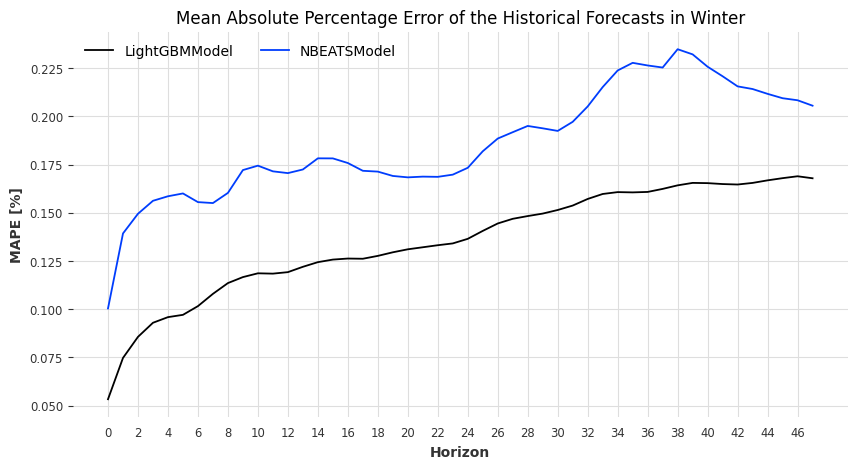

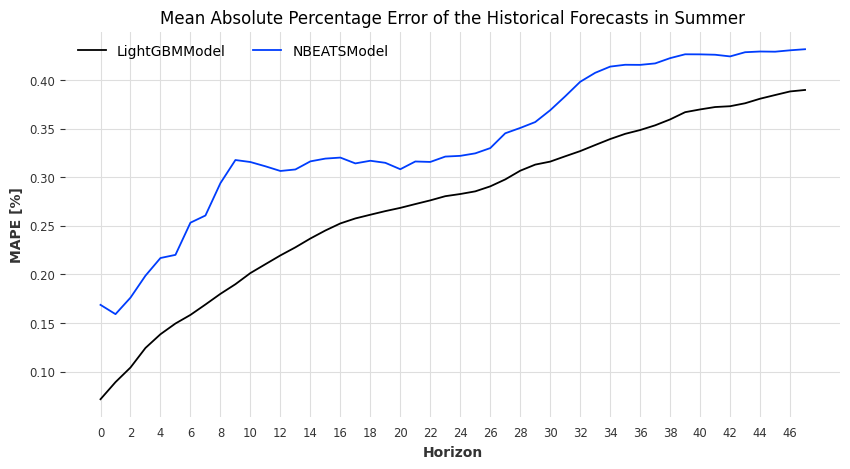

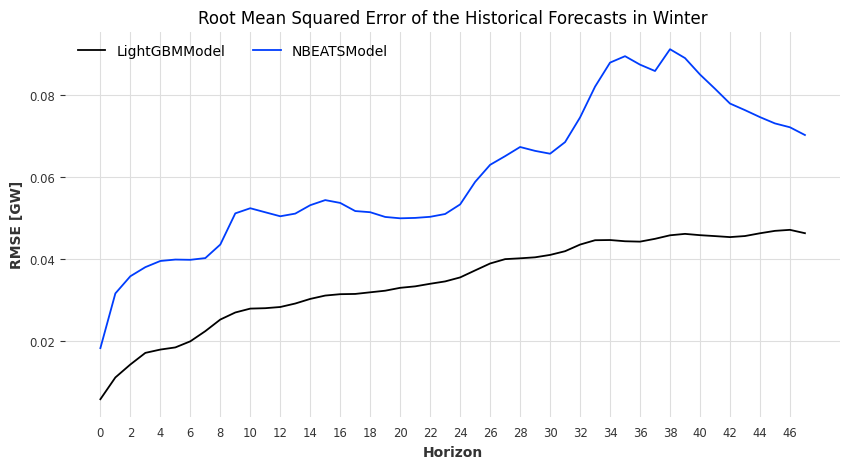

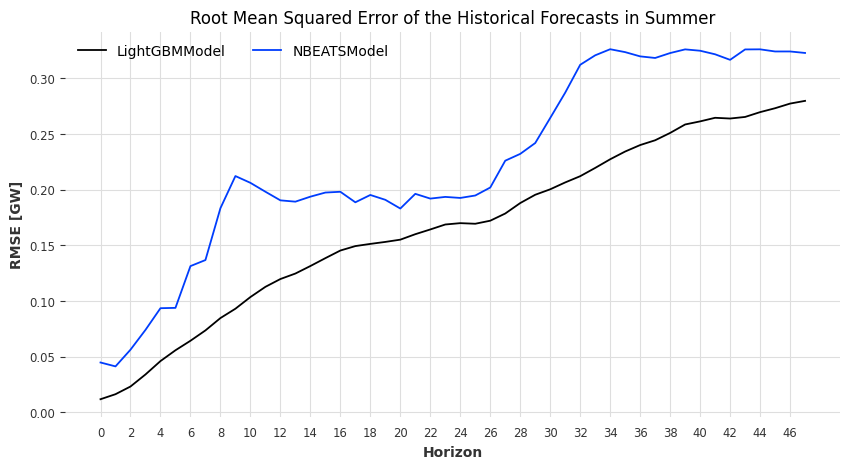

In [115]:

for season in dict_result_season.keys():
    fig = df_smapes_per_season[season].plot(figsize=(10,5))
    plt.xlabel('Horizon')
    plt.ylabel('MAPE [%]')
    plt.legend(loc = 'upper left', ncol = 2)
    plt.xticks(np.arange(0, n_ahead, 2))
    plt.title(f"Mean Absolute Percentage Error of the Historical Forecasts in {season}")
    wandb.log({f"MAPE of the Historical Forecasts in {season}": wandb.Image(fig)})
    
for season in dict_result_season.keys():
    fig = df_nrmse_per_season[season].plot(figsize=(10,5))
    plt.xlabel('Horizon')
    plt.ylabel(f'RMSE [{ts_train[0].components[0][-2:]}]')
    plt.xticks(np.arange(0, n_ahead, 2))
    plt.legend(loc = 'upper left', ncol = 2)
    plt.title(f"Root Mean Squared Error of the Historical Forecasts in {season}")
    wandb.log({f"RMSE of the Historical Forecasts in {season}": wandb.Image(fig)})

### Plot 3: Error distribution

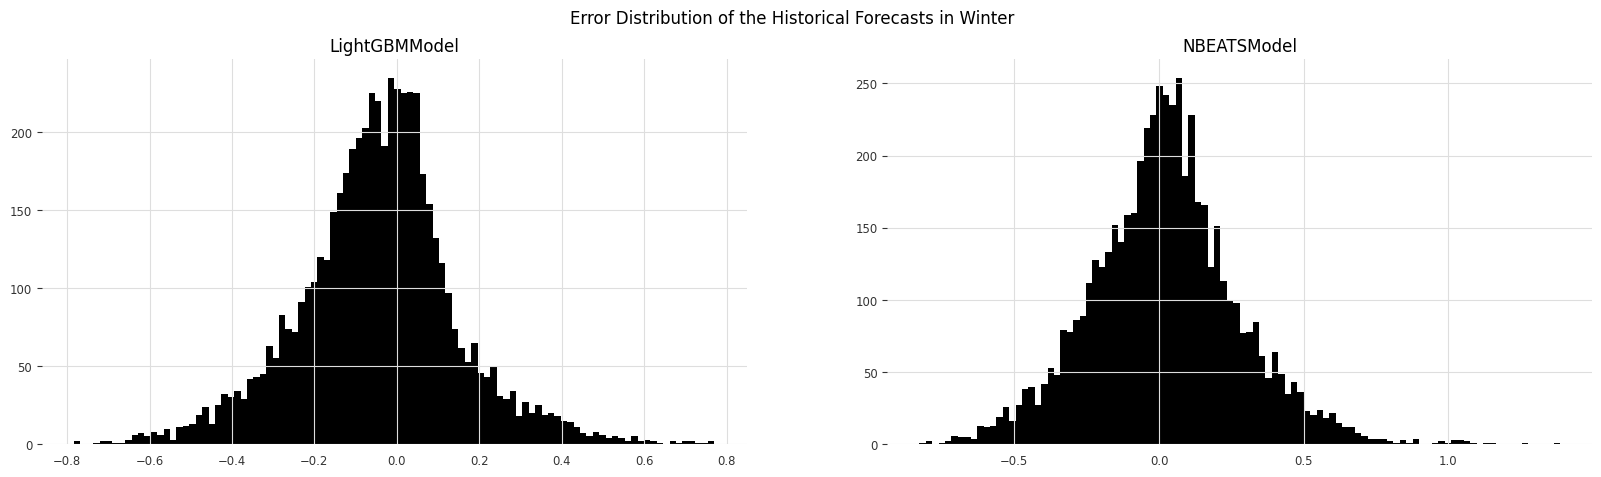

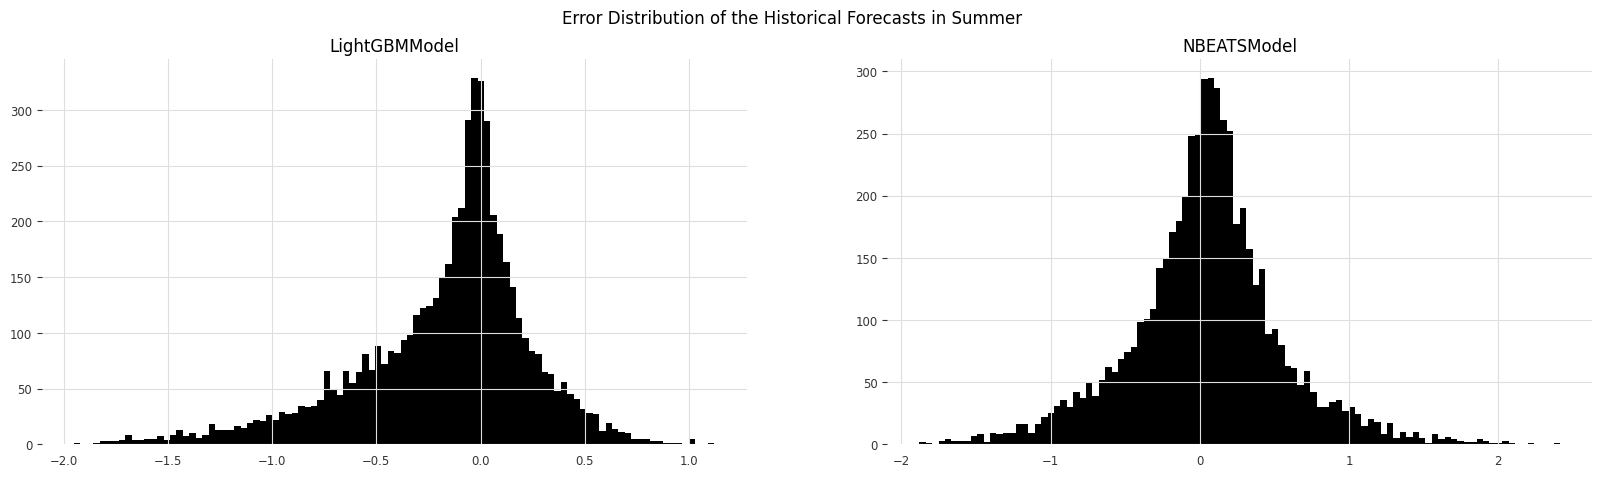

In [116]:
for season, (historics_per_model, _, gt) in dict_result_season.items():
    df_smapes_per_model = []
    df_nrmse_per_model = []
    fig, ax = plt.subplots(ncols=len(model_names[:-2]), figsize=(5*len(model_names),5))
    fig.suptitle(f"Error Distribution of the Historical Forecasts in {season}")
    for i, (model_name, historics) in enumerate(historics_per_model.items()):
        df_list = get_df_compares_list(historics, gt)
        diffs = get_df_diffs(df_list)
        diffs_flat = pd.Series(diffs.values.reshape(-1,))
        ax[i].hist(diffs_flat, bins=100)
        ax[i].set_title(model_name)
    
    wandb.log({f"Error Distribution of the Historical Forecasts in {season}": wandb.Image(fig)})
    plt.show()



### Plot 4: Per Day

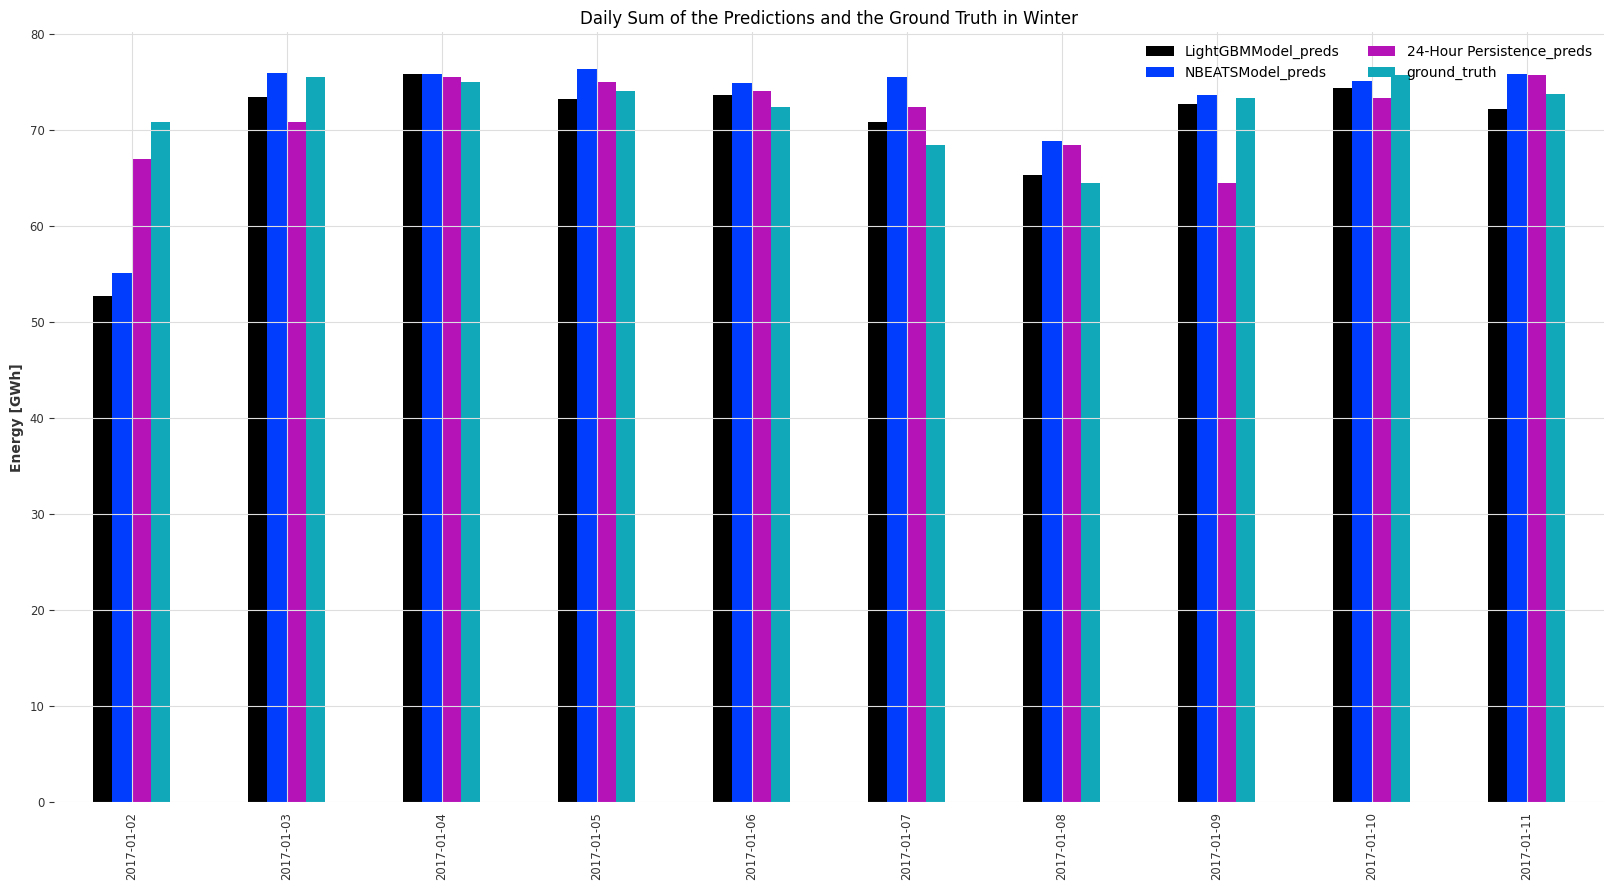

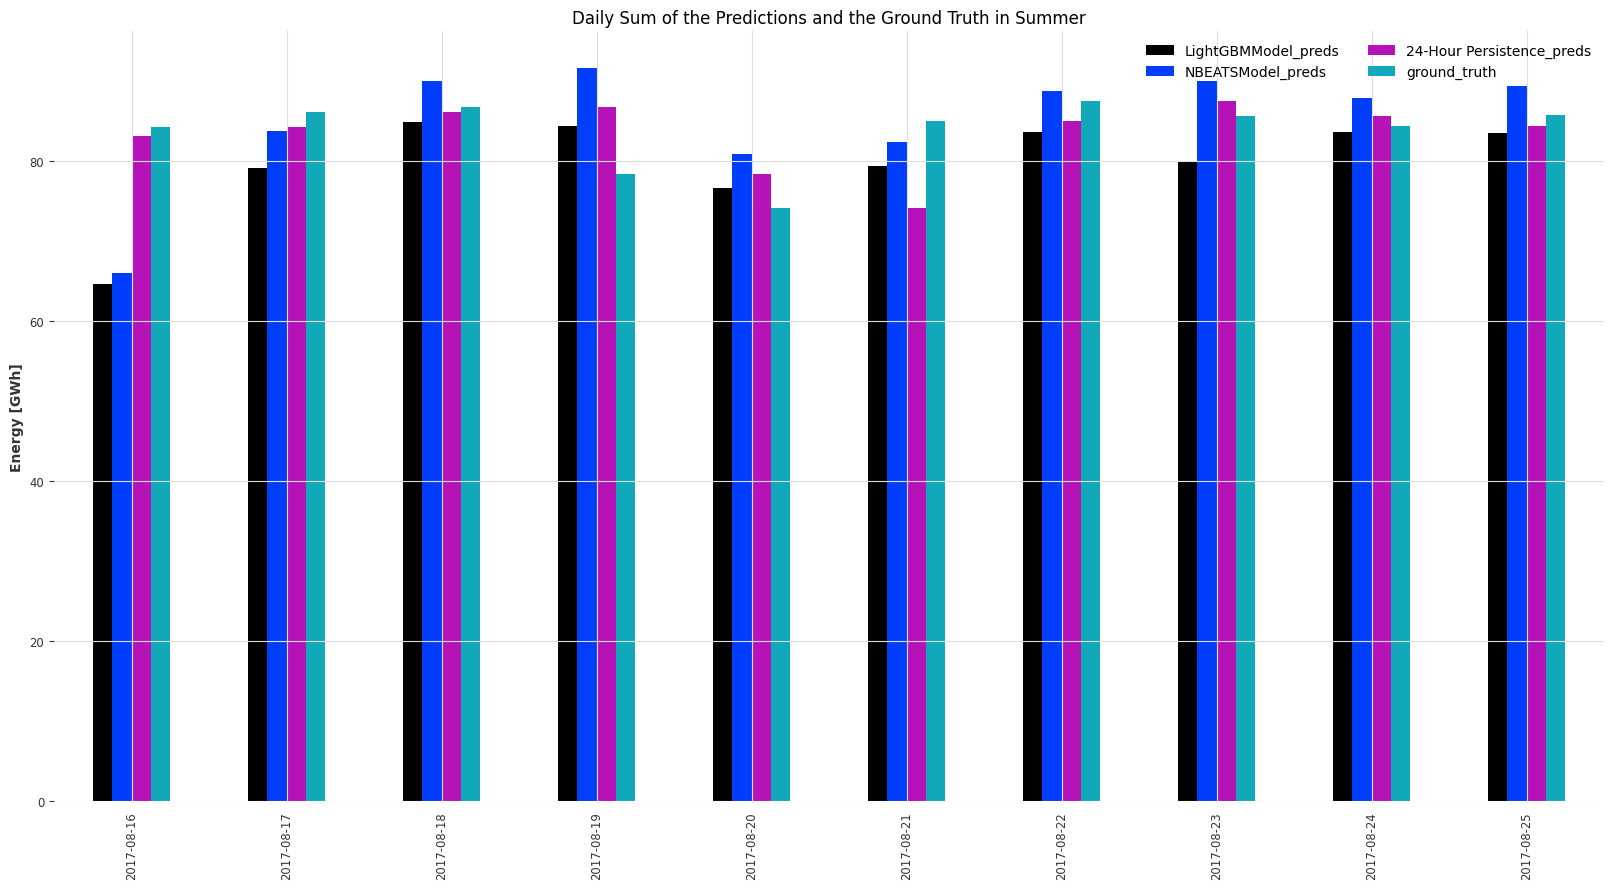

In [117]:
for season, (_, preds_per_model, gt) in dict_result_season.items():
    dfs_daily_sums = []
    for model_name, preds in preds_per_model.items():
        df_preds = preds.pd_series().to_frame(model_name + "_preds")
        z = df_preds.groupby(df_preds.index.date).sum()
        dfs_daily_sums.append(z)

    df_gt = gt.pd_series().to_frame("ground_truth") 
    z = df_gt.groupby(df_gt.index.date).sum() / timesteps_per_hour
    dfs_daily_sums.append(z)
    df_compare = pd.concat(dfs_daily_sums, axis=1).dropna()
    fig = df_compare[:10].plot(kind='bar', figsize=(20,10))
    plt.legend(loc = 'upper right', ncol = 2)
    plt.ylabel(f'Energy [{ts_train[0].components[0][-2:]}h]')
    plt.title(f"Daily Sum of the Predictions and the Ground Truth in {season}")
    wandb.log({f"Daily Sum of the Predictions and the Ground Truth in {season}": wandb.Image(fig)})


In [170]:
wandb.finish()